In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
import torch
import numpy as np
import utils
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%load_ext autoreload
np.random.seed(2) 
torch.manual_seed(2)

In [3]:
lcs = utils.get_data('../../datasets/ZTF_gi', split=1.0)


validated 3407 files out of 3407 for band='i'
validated 3408 files out of 3408 for band='g'
created union_tp attribute of length 3500
dataset created w/ shape (2577, 2, 2420, 3)
train size: 2577, valid size: 0, test size: 0


In [4]:
net, optimizer, args, epoch, loss, train_loss, test_loss = utils.load_checkpoint('../checkpoints/final/ZTF_gi0.7846385836601257.h5', lcs.data_obj)


=> loading checkpoint '../checkpoints/final/ZTF_gi0.7846385836601257.h5'
Namespace(n_union_tp=3500, data_folder='datasets/ZTF_gi', checkpoint='datasets/ZTF_gi0.7817571759223938.h5', start_col=1, inc_errors=False, print_at=1, embed_time=128, enc_num_heads=16, latent_dim=64, mixing='concat', num_ref_points=16, rec_hidden=128, width=512, save_at=30, patience=100, early_stopping=False, niters=20000, frac=0.5, batch_size=2, mse_weight=5.0, dropout=0.0, num_resamples=0, lr=1e-05, scheduler=False, warmup=4000, kl_zero=False, kl_annealing=True, net='hetvae', device='mps', const_var=False, var_per_dim=False, std=0.1, seed=2, save=True, k_iwae=1)


In [5]:
qzs,disc_path = utils.encode(lcs.data_obj['train_loader'], net, device='mps')

  0%|                                                                                                                                                                    | 0/1289 [00:00<?, ?it/s]/Users/mattlowery/Desktop/Desko/code/astro/hetast/src/layers.py:84: UserWarning: The operator 'aten::repeat_interleave.self_int' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1660029059141/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  scores = scores.unsqueeze(-1).repeat_interleave(dim, dim=-1)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1289/1289 [00:27<00:00, 46.44it/s]


In [6]:
num_ref_points = 16 #args.num_ref_points
latent_dim = 64     #args.latent_dim

l = len(lcs.dataset)

In [7]:
n_samples = 10
zs = (np.random.randn(n_samples, qzs.shape[0], qzs.shape[2],qzs.shape[3]) * qzs[:,1,:,:] + qzs[:,0,:,:]).mean(0)

In [8]:
print(zs.shape,disc_path.shape)

(2577, 16, 64) (2577, 16, 64)


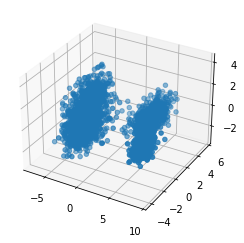

In [9]:
RS = 20150101
pca = PCA(random_state=RS)
pca3d = pca.fit_transform(zs.reshape(zs.shape[0],-1)) 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pca3d[:,0],pca3d[:,1],pca3d[:,2])

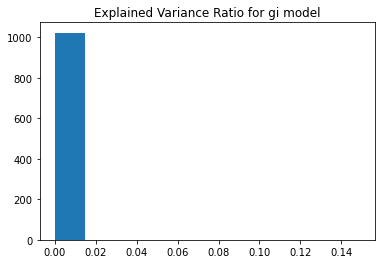

In [13]:
plt.hist(pca.explained_variance_ratio_)
plt.title('Explained Variance Ratio for gi model')
plt.savefig('../img/pcavar_gi')

In [192]:
print(abs(pca.components_).shape)
# for a particular principle component, how does varying it affect variability? 
# if it affects variability in a way we are curious about, which features contribute most to it? 
# should we toggle them? 


(1024, 1024)


(array([110., 207., 291., 403., 426., 330., 217., 191., 117.]),
 array([-1.72626514, -1.35930809, -0.99235105, -0.625394  , -0.25843695,
         0.10852009,  0.47547714,  0.84243419,  1.20939123,  1.57634828]),
 <BarContainer object of 9 artists>)

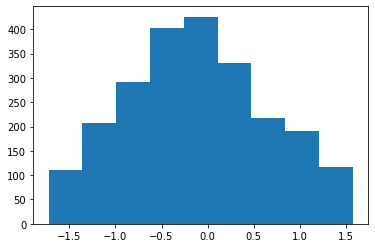

In [208]:
r1,r2 = np.min(pca3d[:,3]), np.max(pca3d[:,10])
bins1 = np.arange(r1,r2, step=(r2-r1)/10)
plt.hist(pca3d[:,0],bins=bins1)

In [209]:
bin_i = np.digitize(pca3d[:,2],bins=bins1)

In [210]:
### avg qzs and disc encodings for each bin in the space 
avgs = [np.concatenate((zs[bin_i==i].mean(0)[np.newaxis],disc_path[bin_i==i].mean(0)[np.newaxis]), axis=0) \
 for i in range(1,len(bins)+1)]
avgs = np.array(avgs,dtype=np.float32)

In [211]:
target_tp = np.arange(0,1500,step=0.5, dtype=np.float32)
target_tp = target_tp[np.newaxis].repeat(len(lcs.bands),axis=0)[np.newaxis].repeat(len(bins1),axis=0)

In [212]:
interps = utils.decode(net,zs=avgs[:,0],disc_path=avgs[:,1],target_x=target_tp,device='mps', batch_size=2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.44s/it]


In [213]:
interps.shape

(10, 1, 3000, 3)

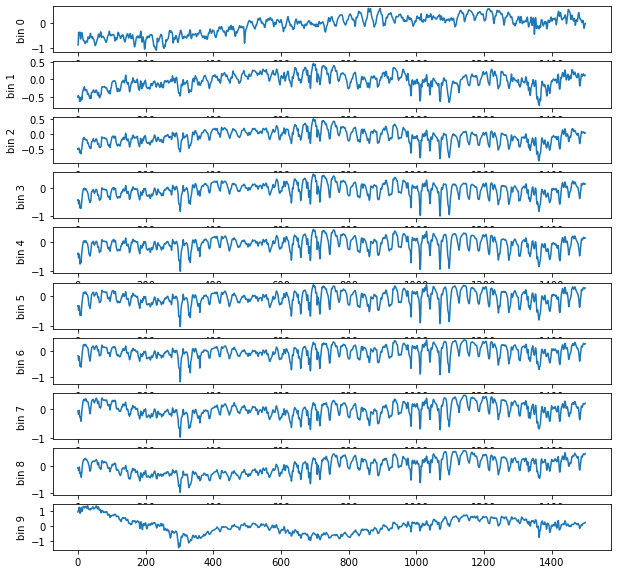

In [214]:
n=len(interps)
dims = len(lcs.bands)
figsize=(10,10)
fig,ax = plt.subplots(n,dims,figsize=figsize, squeeze=False)
for ex in range(n):
    ax[ex,0].set_ylabel(f'bin {ex}')
    for band in range(dims):
        ax[ex,band].plot(interps[ex,band,:,0],interps[ex,band,:,1])
#plt.savefig('../img/pca_grid_exp_1d_g')

In [ ]:
# avgs = [np.concatenate((zs[(bin_i==i) & (bin_j==j)].mean(0)[np.newaxis],disc_path[(bin_i==i) & (bin_j==j)].mean(0)[np.newaxis]), axis=0) \
#  for i in range(1,len(bins1)+1) \
#        for j in range(1,len(bins2)+1)]

# avgs = np.array(avgs,dtype=np.float32)